In [1]:
import numpy as np
rng = np.random.default_rng(seed = 37)

import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import os

import torch as t
import torchvision as tv
from torchvision.transforms import v2
#from torchinfo import summary

from tqdm import tqdm

from PIL import Image

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/Shareddrives/Diffeomorphisms_&_CNNs/Alex/scripts')

device = t.device("cuda") if t.cuda.is_available() else t.device("cpu")
print(f'Using {device} for inference')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using cpu for inference


In [2]:
from tqdm import tqdm

In [17]:
layer_num = 49
read_path = '/content/drive/Shareddrives/Diffeomorphisms_&_CNNs/Alex/data/'
data_dir_list = [s for s in os.listdir(read_path) if f'layer-{layer_num:02d}' in s and '20-50-10-10-3-224-224' in s]

In [19]:
activation = t.zeros((len(data_dir_list), 1000, 1000))
for counter, file_path in enumerate(tqdm(data_dir_list)):
  activation[counter] = t.load(read_path + file_path, map_location = t.device('cpu'))

100%|██████████| 33/33 [00:26<00:00,  1.24it/s]


In [5]:
activation.shape

torch.Size([20, 1000, 64, 28, 28])

In [6]:
activation = activation.reshape(len(data_dir_list), 20, 50, 64, 28, 28) # img, strengh, diffeo, channel, xy

In [7]:
matrix_norm_avg_channel = (t.linalg.matrix_norm(activation - activation[:,0,:][:,None,:,:,:]))/t.linalg.matrix_norm(activation[:,0][:,None,:,:,:])

In [8]:
save_path = '/content/drive/Shareddrives/Diffeomorphisms_&_CNNs/Alex/analysis_saves/'

In [9]:
t.save(matrix_norm_avg_channel, save_path + f'layer_{layer_num:02d}_matrix_norm.pt')

In [10]:
similarity_averaged = t.mean(matrix_norm_avg_channel, dim = (0, 2, 3))

In [11]:
diffeo_amp = t.linspace(0, 1.5, 20)

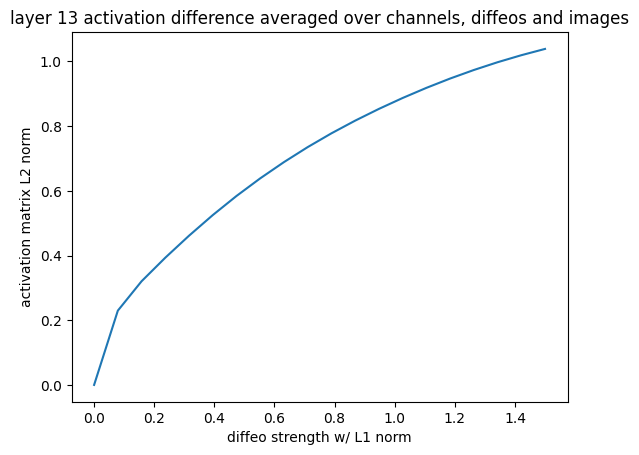

In [12]:
plt.plot(diffeo_amp, similarity_averaged);
plt.xlabel('diffeo strength w/ L1 norm');
plt.ylabel('activation matrix L2 norm');
plt.title(f'layer {layer_num} activation difference averaged over channels, diffeos and images');

In [20]:
activation = t.nn.functional.normalize(activation.reshape(len(data_dir_list),20,50,-1), dim = -1)

In [21]:
cosine_similarity = t.einsum('abcx, abcx -> abc', (activation), (activation[:,0][:,None,:,:]))

In [22]:
t.save(cosine_similarity, save_path + f'layer_{layer_num:02d}_cosine_similarity.pt')

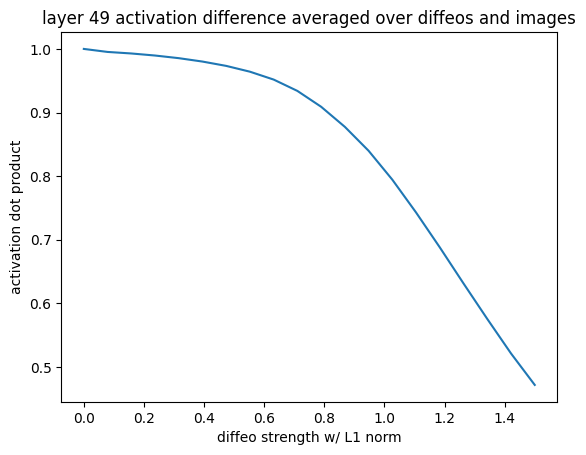

In [23]:
plt.plot(diffeo_amp, cosine_similarity.mean(0).mean(-1));
plt.xlabel('diffeo strength w/ L1 norm');
plt.ylabel('activation dot product');
plt.title(f'layer {layer_num} activation difference averaged over diffeos and images');